#HW5: Autoencoders

In this homework, we will explore how to develop a simple Autoencoder. As a dataset, we will use the MNIST dataset. It contains handwritten digits images.
In the first part, we will learn how to develop a simple shallow autoencoder, then we will develop a deep version. Next, we will experiment with the application of autoencoder on denoising data task (denoising-autoencoder). Finally, we will apply this model to sequential domains, considering the IMDB dataset, already used in HW4.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

###Load Dataset
We load the MNIST dataset, using tf.keras.datasets. The dataset contains 60,000 training images and 10,000 testing images.
The value of each pixel is between 0 and 255, and it represents a point of an image of size 28 x 28. We will normalize all values between 0 and 1, and we will flatten the 28x28 images into vectors of size 784.
Finally, since no validation set is defined, we split the test set in a validation set and a new test set.

In [ ]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid = x_train[:10000]
x_train = x_train[10000:]

11493376/11490434 [==============================] - 0s 0us/step


##[TO COMPLETE] Exercise 5.1: Singular Value Decomposition

Principal component analysis (PCA) and singular value decomposition (SVD) are both classical linear dimensionality reduction methods that attempt to find linear combinations of features in the original high dimensional data matrix to construct a meaningful representation of the dataset.
In this first part of the HW, we will focus our attention on SVD decomposition, a numerical stable method. Given a matrix X, the SVD decomposes it into the product of two unitary matrices V and U and a rectangular diagonal matrix of singular values S:

$$ X=V \cdot S \cdot U^T.$$

SVD is already implemented in NumPy as np.linalg.svd. In our case, the X matrix will represent the training set, where each row is a sample (therefore the number of columns will be the number of input features).

Note that, the X matrix in our case will have a huge number of rows (we have 50000 input samples) and only 784 columns. Therefore to optime the memory consumption, we can compute the SVD of the covariance matrix. An interesting property of the SVD is that we compute the decomposition of the covariance matrix $C= X^T \cdot X$, and we will obtain the following decomposition:

$$ C= U \cdot S^2 \cdot U^T$$

Since we need just the matrix U to compute the compressed version of our data, this method will be very convenient. If you are using the collab free plan, the quantity of available ram is not sufficient to compute the SVD of X, therefore computing the SVD of the covariance matrix turns out to be the best solution. 

In [ ]:
def svd_k(X, k):
  # Compute covariance matrix
  C = np.dot(X.T, X)
  # SVD decomposition
  U, s_sqr, U_T = np.linalg.svd(C, full_matrices=False)
  # Limit the number columns of U to k
  U_k=U[:,:k]
  return U_k


Let's define the ENCODING_DIM, that will be the size of the compressed version of input data. And compute the compressed version of the training set and the test set.

**[TO COMPLETE]**: What happens varying the ENCODING_DIM? test  and discuss the results in a new cell after the following one.

In [ ]:
ENCODING_DIM = 120

U_k=svd_k(x_train, ENCODING_DIM)

x_training_pca = np.dot(x_train, U_k)
x_test_pca = np.dot(x_test, U_k)

print(x_training_pca.shape)
print(x_test_pca.shape)

(50000, 120)
(10000, 120)


By varying ENCODING_DIM, we can control the dimension of the compressed versions of the training and test set. In particular, by varying this parameter with choose how many columns of U we keep. This results in a compression of the train and test images that results in a loss of quality and consequently a decrease of perfomance of the model. 



Reconstruct the input and check how much information was lost due to the compression, by computing the mean squared error between the original input and the reconstruction, and by plotting the reconstructed images.

In [ ]:
x_training_reco= np.dot(x_training_pca, U_k.T)
x_test_reco= np.dot(x_test_pca, U_k.T)




In [ ]:
accuracy_train = ((x_train - x_training_reco)**2).mean()
accuracy_test = ((x_test - x_test_reco)**2).mean()

print("training mse: %.5f" % ( accuracy_train))
print("test mse: %.5f" % ( accuracy_test))

training mse: 0.00464
test mse: 0.00455


In [ ]:
def plot_img(n, input_data, decoded_imgs):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(input_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

Let's check how well the input can be reconstructed by printing a few of the input images and the corresponding reconstructions. Obviously, all these evaluations have to be done on the test set.

The first row of shown images corresponds to input data, while the second one contains the reconstructions.

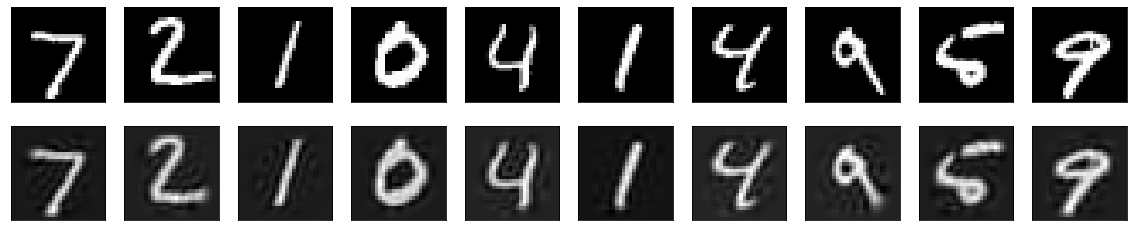

In [ ]:
plot_img(10, x_test, x_test_reco)

## [TO COMPLETE] Exercise 5.2: Shallow Linear Autoencoder
Let's define a model that consists of a single fully-connected neural layer. The hidden layer and the output layer act as the encoder and the decoder, respectively. Differently than the previous homework, instead of using Keras.Sequential(), we define the various part of the model (encoder and decoder) separately and then we create the final model. 

**[TO COMPLETE]** check the results and compare them versus the results obtained with the SVD. Add a cell  at the end of this section (after the result of the linear autoencoder) where you give an explanation of the relation between the results obtained  by the shallow linear autoencoder and the ones obtained by the SVD decomposition.


In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))
#Define the encoder...
encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='linear')(input_img)

#...and the decoder...
decoded = tf.keras.layers.Dense(784, activation='linear')(encoded)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoded)

# In order to visualize the learned encoding, define a model that computes the 
# two parts separately.
encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

#Finally, let's call the compile method
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')


Print the model summary.

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 120)               94200     
_________________________________________________________________
dense_1 (Dense)              (None, 784)               94864     
Total params: 189,064
Trainable params: 189,064
Non-trainable params: 0
_________________________________________________________________


Train the model.

In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/15
98/98 [==============================] - 3s 9ms/step - loss: 0.0814 - val_loss: 0.0140
Epoch 2/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0125 - val_loss: 0.0098
Epoch 3/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0085 - val_loss: 0.0068
Epoch 4/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0066 - val_loss: 0.0060
Epoch 5/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0055
Epoch 6/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 7/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0054 - val_loss: 0.0052
Epoch 8/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 9/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 10/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0049
Epoch 11/15
98/98 [

Plot the loss and the accuracy curves on the validation set, and the accuracy on the test set.


In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

313/313 - 0s - loss: 0.0048
test mse: 0.00480


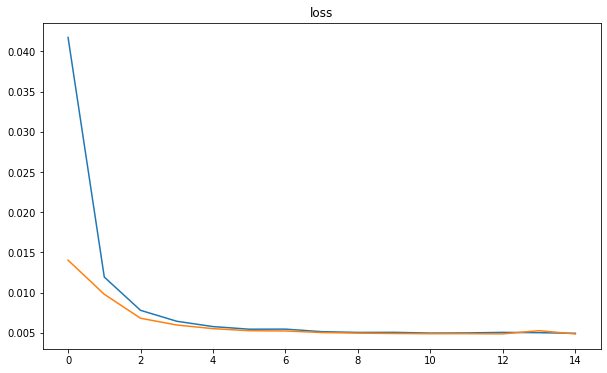

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

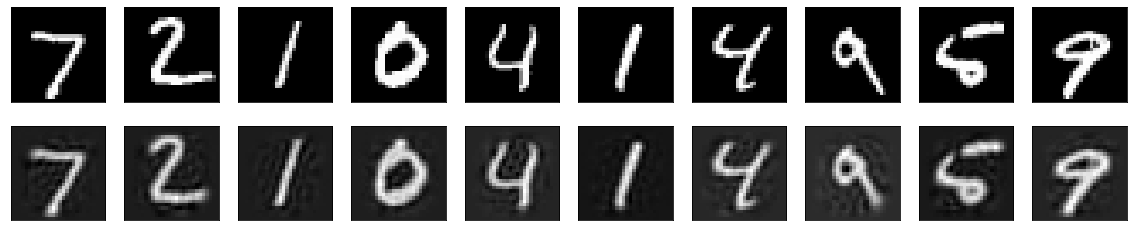

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)


The results are pretty similar, since by using linear activations on an autoencoder we basically obtain the same functionality as SVD. 
<br>In particular, SVD obtained a 0.00455 mean squared error on the test set, while the shallow linear autoencoder obtained a 0.00480 mean squared error on the test set.

##[TO COMPLETE] Exercise 5.3: Shallow non-linear autoencoders

**[TO COMPLETE]** replicate the code of Exercise 5.2 but in this case, instead of using linear activation functions use  non-linear ones. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained in Exercise 5.2. (Insert your code and  theoretical discussion into  cells immediately below this one.)


Epoch 1/15
98/98 [==============================] - 1s 7ms/step - loss: 0.0752 - val_loss: 0.0352
Epoch 2/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0316 - val_loss: 0.0226
Epoch 3/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0208 - val_loss: 0.0164
Epoch 4/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0155 - val_loss: 0.0130
Epoch 5/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0123 - val_loss: 0.0108
Epoch 6/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0104 - val_loss: 0.0093
Epoch 7/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 8/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0080 - val_loss: 0.0074
Epoch 9/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0072 - val_loss: 0.0067
Epoch 10/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 11/15
98/98 [

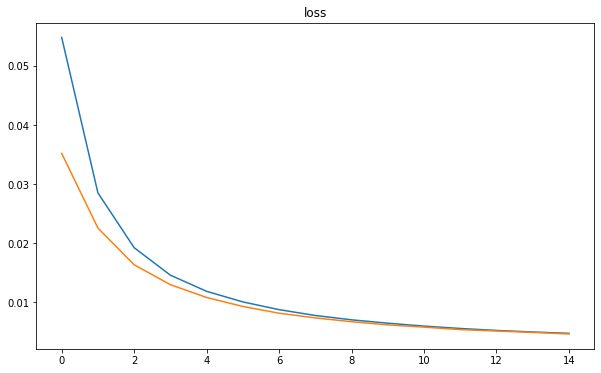

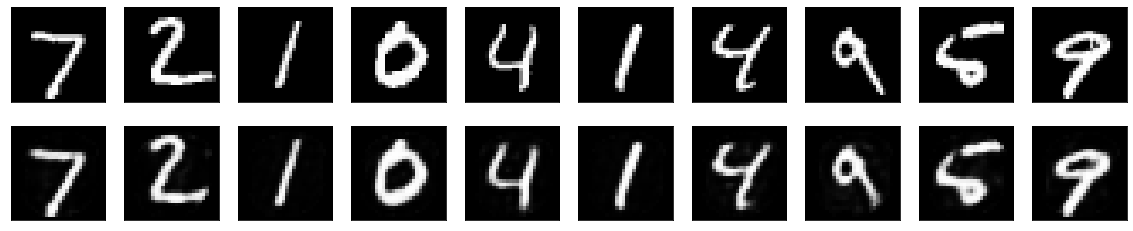

In [ ]:
ENCODING_DIM = 120

input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)


encoder = tf.keras.models.Model(input_img, encoded)
encoded_input = tf.keras.layers.Input(shape=(ENCODING_DIM,))
decoder_layer = autoencoder.layers[-1]
decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))


autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

history = autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid, x_valid))

plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

plot_img(10, x_test, decoded_imgs)

I choose the sigmoid activation function for the encoder because it obtained the best results among the other I tested (ReLu, tanh and ELU). For the decoder I also chosed the sigmoid. This model obtained a test set loss of 0.00453. This result is comparable with the ones obtained with SVD and linear autoencoder, even if we have used non-linear activation function.



##[TO COMPLETE] Exercise 5.4: Deep Autoencoder
**[TO COMPLETE]**: Define a deep version of the Autoeancoder defined above. The autoencoder has to use at least 5 layers. The model will use $n$ layers for encoding, and n-1 for decoding. The layers sizes of the encoding part decrease at each layer (i.e. 784->128->64, where 64 is the encoding dim). The decoding part layers dimensions progression turns out to be mirrored (i.e 128->784, the resulting overall structure recalls an hourglass).
Similarly than what we did above, print the model summary, the loss curves during the training, the achieved loss on the test set, and some input images with the corresponding decoding.


In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))

ENCODING_DIM = 64

#Define the encoding layers 
encoder_1 = tf.keras.layers.Dense(128, activation='relu')(input_img)
encoder_2 = tf.keras.layers.Dense(64, activation='relu')(encoder_1)

#Define the decoding layers 
decoder_1 = tf.keras.layers.Dense(128, activation='relu')(encoder_2)
decoder_2 = tf.keras.layers.Dense(784, activation='sigmoid')(decoder_1)

#and finally the autoencoder
autoencoder = tf.keras.models.Model(input_img, decoder_2)

autoencoder.compile(optimizer='adam', loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_9 (Dense)              (None, 784)               101136    
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = autoencoder.fit(x_train, x_train, epochs=20, batch_size= 512, shuffle=True, validation_data=(x_valid, x_valid))

Epoch 1/20
98/98 [==============================] - 1s 7ms/step - loss: 0.1208 - val_loss: 0.0486
Epoch 2/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0441 - val_loss: 0.0336
Epoch 3/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0314 - val_loss: 0.0253
Epoch 4/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0242 - val_loss: 0.0210
Epoch 5/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0206 - val_loss: 0.0185
Epoch 6/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0182 - val_loss: 0.0166
Epoch 7/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0165 - val_loss: 0.0154
Epoch 8/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0152 - val_loss: 0.0144
Epoch 9/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0143 - val_loss: 0.0136
Epoch 10/20
98/98 [==============================] - 1s 6ms/step - loss: 0.0134 - val_loss: 0.0127
Epoch 11/20
98/98 [

313/313 - 0s - loss: 0.0085
test mse: 0.00854


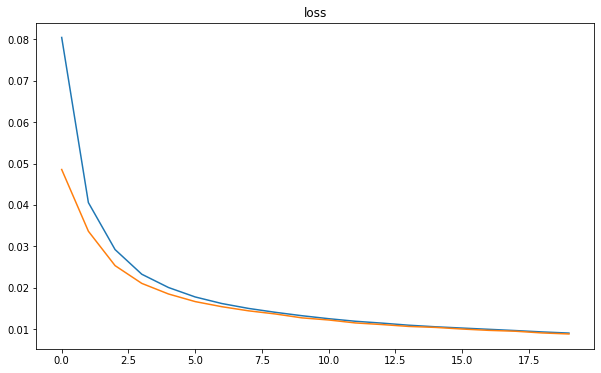

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test, x_test, verbose=2)
print("test mse: %.5f" % (scores))

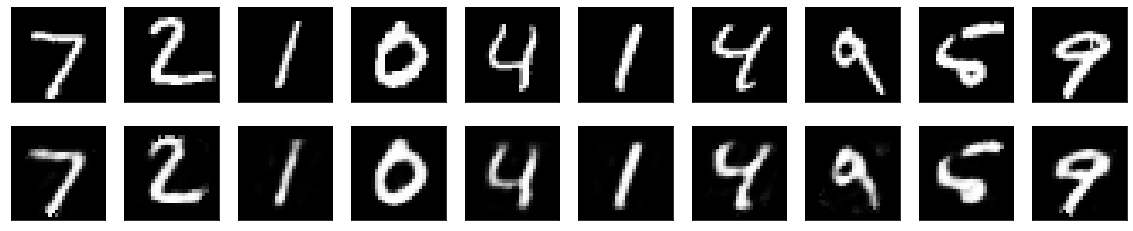

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

plot_img(10, x_test, decoded_imgs)


## [TO COMPLETE] Exercise 5.5: Denoising Autoencoder

Let's now use a shallow autoencoder to denoise the input data.
Firstly, define a noisy input by adding some noise to our input data. We define a noise factor that can be used to modify the amount of noise to add to the input data. Check how much it influences the denoising capability of the autoencoder. **NOTE: in the code at the bottom noise_factor is added and not multiplied for numerical reasons. You may want to try the version with multiplication to verify it is more unstable.**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

x_valid, y_valid = x_train[:10000],y_train[:10000]
x_train, y_train = x_train[10000:],y_train[10000:]

noise_factor = 0.3

x_train_noisy = x_train + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_valid_noisy = x_valid + noise_factor + np.random.normal(loc=0.0, scale=1.0, size=x_valid.shape)


x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)

Plot some noisy inputs.

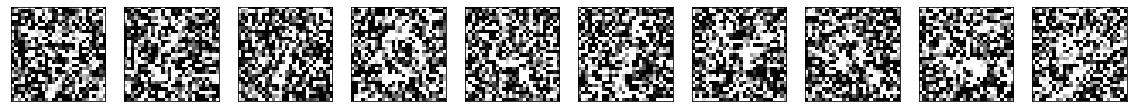

In [ ]:
# here's what the noisy digits look like
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**[TO COMPLETE]** Define a shallow autoencoder able to compute a de-noised version of the input (obtained by unsing a noise_factor >= 0.3). 

In [ ]:
input_img = tf.keras.layers.Input(shape=(784,))

encoded = tf.keras.layers.Dense(ENCODING_DIM, activation='sigmoid')(input_img)

decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

autoencoder = tf.keras.models.Model(input_img, decoded)

autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse')

In [ ]:
autoencoder.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_19 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


**[TO COMPLETE]** Train the model by passing the noisy input and the clean target.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train, epochs=15, batch_size=512, shuffle=True, validation_data=(x_valid_noisy, x_valid))

Epoch 1/15
98/98 [==============================] - 1s 7ms/step - loss: 0.0867 - val_loss: 0.0627
Epoch 2/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0609 - val_loss: 0.0569
Epoch 3/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0561 - val_loss: 0.0540
Epoch 4/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0537 - val_loss: 0.0530
Epoch 5/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0530 - val_loss: 0.0514
Epoch 6/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0512 - val_loss: 0.0499
Epoch 7/15
98/98 [==============================] - 1s 6ms/step - loss: 0.0495 - val_loss: 0.0490
Epoch 8/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0489 - val_loss: 0.0484
Epoch 9/15
98/98 [==============================] - 0s 5ms/step - loss: 0.0485 - val_loss: 0.0483
Epoch 10/15
98/98 [==============================] - 1s 5ms/step - loss: 0.0484 - val_loss: 0.0481
Epoch 11/15
98/98 [

313/313 - 0s - loss: 0.0477
test mse: 0.04770


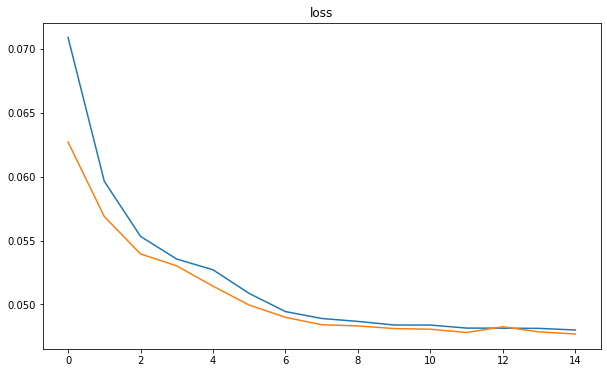

In [ ]:
plot_loss(history)

scores = autoencoder.evaluate(x_test_noisy, x_test, verbose=2)
print("test mse: %.5f" % (scores))

**[TO COMPLETE]** Check the result by plotting some input images and the corresponding denoised outputs.

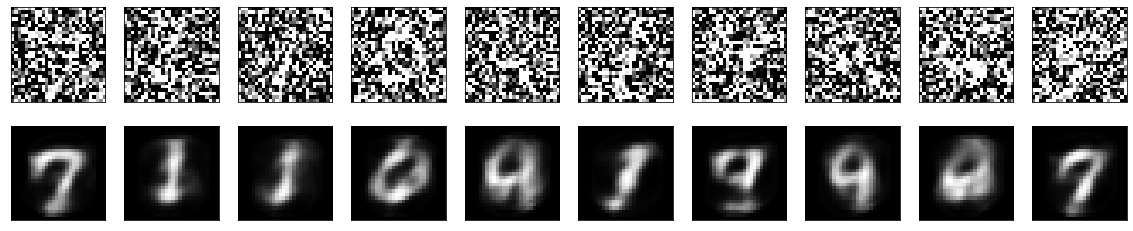

In [ ]:
decoded_imgs = autoencoder.predict(x_test_noisy)

plot_img(10, x_test_noisy, decoded_imgs)

By varying the noise_factor, I obtained the following results:

* *noise_factor* = 0.3 ---> **test mse** = 0.04770
* *noise_factor* = 0.5 ---> **test mse** = 0.05419
* *noise_factor* = 0.7 ---> **test mse** = 0.06315
* *noise_factor* = 0.9 ---> **test mse** = 0.06374


## Exercise 5.6: Linear Autoencoder for sequences

Let's define a linear autoencoder for sequences. In this case, as dataset, we will use the IMDB dataset (already presented in HW4). To have a model that can be trained and tested in a reasonable time (and that works also with the memory limitation that we have in Colab), we will limit the number of training samples and test samples.

In [ ]:
num_words = 100
(X_train, _), (X_test, _) = keras.datasets.imdb.load_data(num_words=num_words)

X_train=X_train[:10000]

(X_valid, X_test) = X_test[:1250], X_test[-1250:]

word_index = keras.datasets.imdb.get_word_index()

reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])


maxlen = 90
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)



17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])


1646592/1641221 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In this case, we want to use as input/target a one-hot representation for each word. To convert the index representation provided by IMDB dataset loader we use the to_categorical method to transform them in the corresponding one hot representation.

In [ ]:
from keras.utils import to_categorical


X_train_one_hot=to_categorical(X_train_trim)
X_test_one_hot=to_categorical(X_test_trim)
X_valid_one_hot=to_categorical(X_valid_trim)


Define a linear shallow autoencoder for sequences. The structure will be similar to the model defined in Exercise 5.2, while the used encoding layer is defined by using tf.keras.layers.SimpleRNN. Note that it uses linear activations. The decoding layer exploits [tf.keras.layers.TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) that allows using the same dense cell at each time step of the sequence. 

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.SimpleRNN(50, return_sequences=True, activation='linear')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='linear'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 90, 50)            7550      
_________________________________________________________________
time_distributed (TimeDistri (None, 90, 100)           5100      
Total params: 12,650
Trainable params: 12,650
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Epoch 1/50
79/79 [==============================] - 8s 89ms/step - loss: 0.2760 - categorical_accuracy: 0.1034 - val_loss: 0.0817 - val_categorical_accuracy: 0.4238
Epoch 2/50
79/79 [==============================] - 7s 86ms/step - loss: 0.0738 - categorical_accuracy: 0.4699 - val_loss: 0.0630 - val_categorical_accuracy: 0.5101
Epoch 3/50
79/79 [==============================] - 7s 84ms/step - loss: 0.0597 - categorical_accuracy: 0.5270 - val_loss: 0.0549 - val_categorical_accuracy: 0.5613
Epoch 4/50
79/79 [==============================] - 7s 87ms/step - loss: 0.0515 - categorical_accuracy: 0.5742 - val_loss: 0.0458 - val_categorical_accuracy: 0.5854
Epoch 5/50
79/79 [==============================] - 7s 85ms/step - loss: 0.0437 - categorical_accuracy: 0.5929 - val_loss: 0.0406 - val_categorical_accuracy: 0.6293
Epoch 6/50
79/79 [==============================] - 7s 86ms/step - loss: 0.0389 - categorical_accuracy: 0.6407 - val_loss: 0.0366 - val_categorical_accuracy: 0.6626
Epoch 7/50

Let's plot the accuracy and the loss trends and check the reconstruction capability of the model by plotting the reconstruction of a test sample

40/40 - 0s - loss: 0.0173 - categorical_accuracy: 0.8924
categorical_accuracy: 89.24%


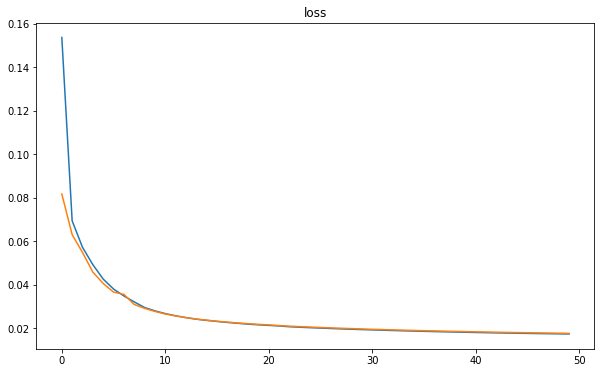

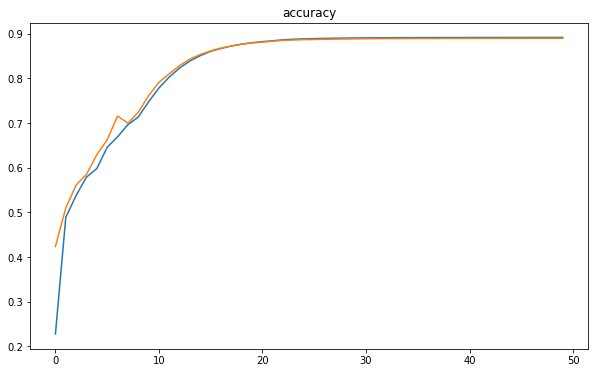

In [ ]:
def plot_categorical_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['categorical_accuracy'])
  plt.plot(history.epoch,history.history['val_categorical_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

In [ ]:
decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in on br that great but that <oov> the <oov> is <oov> a them <oov> film in just br <oov> <oov> <oov> <oov> on a other <oov> have <oov> and it <oov> like <oov> <oov> <oov> the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than they <oov> is <oov> <oov> i <oov> it <oov> the br <oov> and i <oov> <oov> br <oov>


##[TO COMPLETE] Exercise 5.7: Non-Linear Autoencoder for sequences
**[TO COMPLETE]**: Replicate the code of the above exercise, but instead of using a simpleRNN with linear activation do the same  using  non-linear activation functions and using an LSTM layer. Choose the most appropriate non-linear function, and motivate your choice. Then discuss the results in relation to those obtained by the linear autoencoder for sequences.

Hint: using a non-linear function also in the dense layer after the RNN/LSTM one will help to obtain better results. The choice of this function should be based on the type of output data.

In [ ]:
inputs = tf.keras.layers.Input(shape=(maxlen, num_words))
encoded = tf.keras.layers.LSTM(21, return_sequences=True, activation='sigmoid')(inputs)

decoded = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(num_words, activation='softmax'))(encoded)

sequence_autoencoder = tf.keras.models.Model(inputs, decoded)
encoder = tf.keras.models.Model(inputs, encoded)

sequence_autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=["CategoricalAccuracy"])

sequence_autoencoder.summary()

history = sequence_autoencoder.fit(X_train_one_hot, X_train_one_hot, epochs=50, batch_size=128, shuffle=True, validation_data=(X_valid_one_hot, X_valid_one_hot))

Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 90, 100)]         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 90, 21)            10248     
_________________________________________________________________
time_distributed_5 (TimeDist (None, 90, 100)           2200      
Total params: 12,448
Trainable params: 12,448
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
79/79 [==============================] - 16s 186ms/step - loss: 0.0536 - categorical_accuracy: 0.0760 - val_loss: 0.0438 - val_categorical_accuracy: 0.4620
Epoch 2/50
79/79 [==============================] - 14s 183ms/step - loss: 0.0406 - categorical_accuracy: 0.4718 - val_loss: 0.0372 - val_categorical_accuracy: 0.4614
Epoch 3/50
79/79 [==============================] 

40/40 - 1s - loss: 1.9307e-04 - categorical_accuracy: 1.0000
categorical_accuracy: 100.00%
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>
than a <oov> <oov> that are <oov> in all of that time but that <oov> the <oov> is <oov> a very <oov> film in just about <oov> <oov> <oov> <oov> as some other <oov> have <oov> out it <oov> like <oov> <oov> of the film are <oov> <oov> there <oov> other <oov> <oov> <oov> are <oov> <oov> in the <oov> <oov> this is a really bad film that <oov> <oov> <oov> than its <oov> of <oov> <oov> i <oov> it <oov> out of <oov> and i <oov> <oov> very <oov>


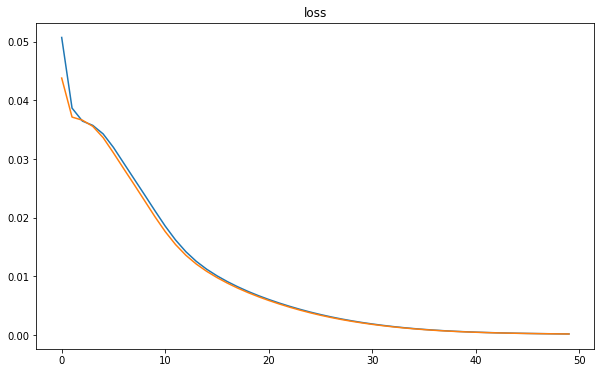

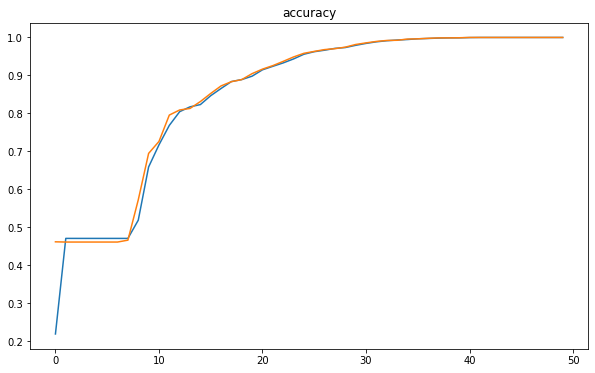

In [ ]:
plot_loss(history)

plot_categorical_accuracy(history)

scores = sequence_autoencoder.evaluate(X_test_one_hot, X_test_one_hot, verbose=2)
print("%s: %.2f%%" % (sequence_autoencoder.metrics_names[1], scores[1]*100))

decoded_text = sequence_autoencoder.predict(X_test_one_hot)
decode_index= np.argmax(decoded_text[500], axis=1)
input_text= np.argmax(X_test_one_hot[500], axis=1)

print(decode_review(input_text))
print(decode_review(decode_index))

In this case, I chose to use the *sigmoid* activation for the encoder and a *softmax* activation for the decoder, since they obtained the best results among other combinations that I have tested (e.g. ReLu/sigmoid, ReLu/tanh, sigmoid/sigmoid, ReLu/ReLu, tanh/tanh). Compared to the linear autoencoder for sequences that we have tested above which obtained an overall categorical accuracy on the test set of 89.24%, the non-linear version obtained the perfect result with 100% categorical accuracy. <br> Notice that I decreased the number of LSTM units to 21 in order to make a fair comparison between the 2 models; in this way, both models have approximately 12,500 trainable parameters.